In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
import numba
from numba import njit
import numpy as np

In [2]:
filename ="/pnfs/psi.ch/cms/trivcat/store/mc/Run3Summer22EENanoAODv12/VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/a897cbbf-ea0b-40d5-b850-f9f24a7906a5.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=10).events()
print("Events read:", len(events))


Events read: 10


# Use the last b quark for the matching of the b-quarks from higgs decay

In [3]:
# add column with the index
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
print(events.GenPart.index[0])
# get last bquark copy
isB = abs(events.GenPart.pdgId) == 5
isLast = events.GenPart.hasFlags(["isLastCopy"])
isHard = events.GenPart.hasFlags(["fromHardProcess"])
bquarks_last = events.GenPart[isB & isLast & isHard]
# print(bquarks_last.pdgId, bquarks_last.genPartIdxMother)
b_quarks = bquarks_last
while True:
    print("\nloop")
    b_mother = events.GenPart[b_quarks.genPartIdxMother]
    print("old: ", "pdg", b_quarks.pdgId, "mother_idx",b_quarks.genPartIdxMother, "pt", b_quarks.pt, "index", b_quarks.index)
    print("mother: ", "pdg", b_mother.pdgId, "mother_idx",b_mother.genPartIdxMother, "pt", b_mother.pt)
    # break
    b_quarks = ak.where(abs(b_mother.pdgId) == 5, b_mother, b_quarks)
    print("new: ", "pdg", b_quarks.pdgId, "mother_idx",b_quarks.genPartIdxMother, "pt", b_quarks.pt)

    print(ak.any(abs(b_mother.pdgId) != 25, axis=1))
    if ak.all(abs(b_mother.pdgId) == 25):
        break

print(b_quarks.pdgId, b_quarks.genPartIdxMother, b_quarks.pt)
print(b_quarks.genPartIdxMother, len(b_quarks.genPartIdxMother))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]

loop
old:  pdg [[5, -5, 5, -5], [-5, 5, 5, -5], [5, -5, ... 5, -5], [5, -5, 5, -5], [5, -5, 5, -5]] mother_idx [[14, 15, 17, 13], [15, 14, 16, 17], [20, ... [12, 14, 15, 16], [12, 13, 14, 15]] pt [[26.9, 28.1, 50.4, 76.2], [27.2, 60.6, 31.9, ... 59.8, 78.5], [219, 60.6, 83.2, 28]] index [[18, 24, 26, 29], [18, 20, 25, 26], [25, ... [21, 27, 29, 30], [19, 20, 23, 24]]
mother:  pdg [[5, -5, 5, -5], [-5, 5, 5, -5], [5, -5, ... 5, -5], [5, -5, 5, -5], [5, -5, 5, -5]] mother_idx [[11, 11, 12, 10], [12, 12, 13, 13], [16, ... [10, 13, 11, 11], [10, 10, 11, 11]] pt [[41.5, 101, 50.4, 91.5], [55.8, 66.5, 71, ... 142, 66.2, 86.8], [223, 67.5, 88, 36]]


new:  pdg [[5, -5, 5, -5], [-5, 5, 5, -5], [5, -5, ... 5, -5], [5, -5, 5, -5], [5, -5, 5, -5]] mother_idx [[11, 11, 12, 10], [12, 12, 13, 13], [16, ... [10, 13, 11, 11], [10, 10, 11, 11]] pt [[41.5, 101, 50.4, 91.5], [55.8, 66.5, 71, ... 142, 66.2, 86.8], [223, 67.5, 88, 36]]
[True, True, True, True, True, True, True, True, True, True]

loop
old:  pdg [[5, -5, 5, -5], [-5, 5, 5, -5], [5, -5, ... 5, -5], [5, -5, 5, -5], [5, -5, 5, -5]] mother_idx [[11, 11, 12, 10], [12, 12, 13, 13], [16, ... [10, 13, 11, 11], [10, 10, 11, 11]] pt [[41.5, 101, 50.4, 91.5], [55.8, 66.5, 71, ... 142, 66.2, 86.8], [223, 67.5, 88, 36]] index [[14, 15, 17, 13], [15, 14, 16, 17], [20, ... [12, 14, 15, 16], [12, 13, 14, 15]]
mother:  pdg [[25, 25, 5, 25], [25, 25, 25, 25], [5, ... 25], [25, -5, 25, 25], [25, 25, 25, 25]] mother_idx [[9, 9, 10, 8], [10, 10, 11, 11], [14, 12, ... 10, 10], [8, 10, 9, 9], [8, 8, 9, 9]] pt [[71.8, 71.8, 132, 195], [66, 66, 43.4, ... 156, 109, 109], [274, 274, 59.6, 59.6]]
new:  pdg 

In [4]:
# order higgs pt
higgs = events.GenPart[
            (events.GenPart.pdgId == 25)
            & events.GenPart.hasFlags(["fromHardProcess"])
            & events.GenPart.hasFlags(["isLastCopy"])
        ]
higgs = higgs[ak.num(higgs.childrenIdxG, axis=2) == 2]
print(higgs.pt, higgs.childrenIdxG, higgs.children.pdgId, higgs.children.pt)
print(ak.argsort(higgs.pt,ascending=False))
print(higgs.index)
higgs=higgs[ak.argsort(higgs.pt,ascending=False)]
print(higgs.pt, higgs.childrenIdxG, higgs.children.pdgId, higgs.children.pt)
print(higgs.index)

provenance = ak.where(b_quarks.genPartIdxMother == higgs.index[:,0], 1, 2)
print(provenance)


[[195, 71.8], [66, 43.4], [28.7, 14.2], ... [110, 67.8], [150, 109], [274, 59.6]] [[[12, 13], [14, 15]], [[67, 68], [69, ... [452, 453]], [[518, 519], [520, 521]]] [[[5, -5], [5, -5]], [[5, -5], [5, -5]], ... [[5, -5], [5, -5]], [[5, -5], [5, -5]]] [[[132, 91.5], [41.5, 101]], [[66.5, 55.8, ... 66.2, 86.8]], [[223, 67.5], [88, 36]]]
[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
[[10, 11], [12, 13], [14, 15], [10, 11], ... [6, 7], [11, 12], [10, 11], [10, 11]]
[[195, 71.8], [66, 43.4], [28.7, 14.2], ... [110, 67.8], [150, 109], [274, 59.6]] [[[12, 13], [14, 15]], [[67, 68], [69, ... [452, 453]], [[518, 519], [520, 521]]] [[[5, -5], [5, -5]], [[5, -5], [5, -5]], ... [[5, -5], [5, -5]], [[5, -5], [5, -5]]] [[[132, 91.5], [41.5, 101]], [[66.5, 55.8, ... 66.2, 86.8]], [[223, 67.5], [88, 36]]]
[[10, 11], [12, 13], [14, 15], [10, 11], ... [6, 7], [11, 12], [10, 11], [10, 11]]
[[2, 2, 1, 1], [1, 1, 2, 2], [1, 1, 2, 2, ... 1, 2, 2], [1, 1, 2, 2], [1, 1, 2, 2]]

# VBF partons

In [5]:
# get mother of higgs
higgs_first_copy=events.GenPart[
            (events.GenPart.pdgId == 25)
            & events.GenPart.hasFlags(["fromHardProcess"])
            & events.GenPart.hasFlags(["isFirstCopy"])]
higgs_mother = events.GenPart[higgs_first_copy.genPartIdxMother]
print(higgs_mother.pdgId)

[[2, 2], [1, 1], [2, 2], [2, 2], [-2, -2], ... 2, 2], [2, 2], [2, 2], [3, 3], [1, 1]]


In [6]:
print(events.GenPart)
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
genpart= events.GenPart
single_event=-1
if (single_event!=-1):
    genpart= events.GenPart[single_event]


isQuark = abs(genpart.pdgId) < 7
isLast = genpart.hasFlags(["isLastCopy"])
isHard = genpart.hasFlags(["fromHardProcess"])


[[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]


In [17]:

vbf_quarks_last = genpart[isQuark & isLast & isHard]
vbf_quarks_last = vbf_quarks_last[vbf_quarks_last.genPartIdxMother!=-1]
vbf_quarks = vbf_quarks_last
print("vbf_quarks_last: ", vbf_quarks_last.pdgId, vbf_quarks_last.genPartIdxMother, vbf_quarks_last.index, ak.num(vbf_quarks_last.pt))

i=0
while True:
    print("\n#############################loop")
    # vbf_quarks=vbf_quarks[vbf_quarks.genPartIdxMother!=-1]
    vbf_quark_mother = genpart[vbf_quarks.genPartIdxMother]
    # mother can't be higgs to avoid getting the quarks from higgs decay
    print("quark_last: ", "pdg", vbf_quarks_last.pdgId, "mother_idx",vbf_quarks_last.genPartIdxMother,"index", vbf_quarks_last.index)
    print("quark: ", "pdg", vbf_quarks.pdgId, "mother_idx",vbf_quarks.genPartIdxMother,"index", vbf_quarks.index)
    print("mother: ", "pdg", vbf_quark_mother.pdgId, "mother_idx",vbf_quark_mother.genPartIdxMother,  "index", vbf_quark_mother.index)
    mother_isnotH = abs(vbf_quark_mother.pdgId) != 25
    vbf_quarks= vbf_quarks[mother_isnotH]
    vbf_quark_mother = vbf_quark_mother[mother_isnotH]
    vbf_quarks_last = vbf_quarks_last[mother_isnotH]
    print("\nquark_last1: ", "pdg", vbf_quarks_last.pdgId, "mother_idx",vbf_quarks_last.genPartIdxMother,"index", vbf_quarks_last.index)
    print("quark1: ", "pdg", vbf_quarks.pdgId, "mother_idx",vbf_quarks.genPartIdxMother,"index", vbf_quarks.index)
    print("mother1: ", "pdg", vbf_quark_mother.pdgId, "mother_idx",vbf_quark_mother.genPartIdxMother,  "index", vbf_quark_mother.index)

    #check if any of the children of mother is a higgs
    mother_children = vbf_quark_mother.children
    print("\nchildren of mother: ", "pdg", mother_children.pdgId, "mother_idx",mother_children.genPartIdxMother,  "index", mother_children.index)
    #cnotain two higgs in the children
    mother_children_isH = ak.sum((mother_children.pdgId == 25), axis=-1)==2
    #NOTE: do we need to check the children of the children as well to see if there are the Higgs?
    print("mother_children_isH", mother_children_isH)

    if ak.all(mother_children_isH):
        break
    vbf_quarks = ak.where(mother_children_isH, vbf_quarks, vbf_quark_mother)
    i+=1


print(vbf_quarks_last.index)


print("\n\nnum of loops", i)
if single_event==-1:
    #check if for each event there are two vbf quarks
    if(ak.any(ak.num(vbf_quarks.pt, axis=-1)!=2)):
        print("\n\nERROR: not two vbf quarks")
        for i in range(len(vbf_quarks)):
            if len(vbf_quarks.pt[i])!=2:
                print("\nevent", i, "number of vbf quarks", len(vbf_quarks.pt[i]))
                print("vbf quark_last : ", "pdg", vbf_quarks_last.pdgId[i], "mother_idx",vbf_quarks_last.genPartIdxMother[i],"index", vbf_quarks_last.index[i])
                print("vbf quark: ", "pdg", vbf_quarks.pdgId[i], "mother_idx",vbf_quarks.genPartIdxMother[i],"index", vbf_quarks.index[i])
                print("mother: ", "pdg", vbf_quark_mother.pdgId[i], "mother_idx",vbf_quark_mother.genPartIdxMother[i],  "index", vbf_quark_mother.index[i])
                print("children: ", "pdg", mother_children.pdgId[i], "mother_idx",mother_children.genPartIdxMother[i],  "index", mother_children.index[i])
        exit(1)

vbf_quarks_last:  [[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, 1], [2, 1, 5, -5, 5, -5]] [[14, 5, 4, 15, 17, 13], [15, 14, 5, 16, ... 14, 15, 16, 5], [4, 5, 12, 13, 14, 15]] [[18, 20, 21, 24, 26, 29], [18, 20, 22, ... 29, 30, 36], [16, 17, 19, 20, 23, 24]] [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

#############################loop
quark_last:  pdg [[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, 1], [2, 1, 5, -5, 5, -5]] mother_idx [[14, 5, 4, 15, 17, 13], [15, 14, 5, 16, ... 14, 15, 16, 5], [4, 5, 12, 13, 14, 15]] index [[18, 20, 21, 24, 26, 29], [18, 20, 22, ... 29, 30, 36], [16, 17, 19, 20, 23, 24]]
quark:  pdg [[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, 1], [2, 1, 5, -5, 5, -5]] mother_idx [[14, 5, 4, 15, 17, 13], [15, 14, 5, 16, ... 14, 15, 16, 5], [4, 5, 12, 13, 14, 15]] index [[18, 20, 21, 24, 26, 29], [18, 20, 22, ... 29, 30, 36], [16, 17, 19, 20, 23, 24]]
mother:  pdg [[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, 1], [2, 1, 5, -5, 5, -

In [8]:
if single_event==-1:
    # check if vbf quark: eta > 2.5 and delta eta >5
    print(vbf_quarks.eta)
    print(abs(vbf_quarks.eta[:,0] - vbf_quarks.eta[:,1]))
    print(vbf_quarks_last.eta)
    print(abs(vbf_quarks_last.eta[:,0] - vbf_quarks_last.eta[:,1]))

[[3.78, -3.41], [-3.66, 4.12], [-2.79, 3.44, ... 2.41], [2.29, -5.47], [3.04, -2.8]]
[7.2, 7.79, 6.23, 6.38, 7.84, 5.05, 4.49, 6.39, 7.76, 5.84]
[[3.9, -3.42], [-3.48, 3.49], [-2.8, 4.11, ... 2.84], [2.43, -5.27], [3.04, -3.03]]
[7.32, 6.98, 6.91, 6.45, 7.97, 5.14, 4.54, 6.83, 7.7, 6.07]


# the quarkVBF which weneed to match to the reco jets are vbf_quarks_last

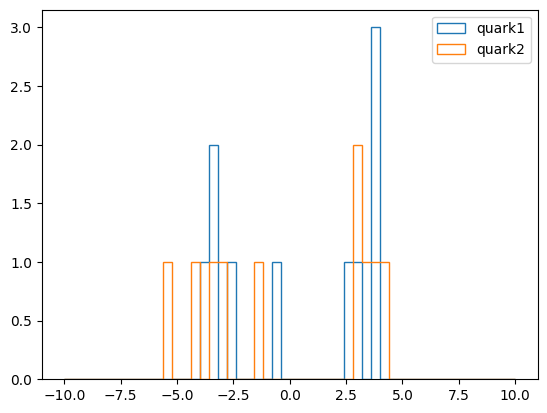

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(vbf_quarks_last.eta[:,0], bins=50, range=(-10,10), histtype='step', label='quark1')
plt.hist(vbf_quarks_last.eta[:,1], bins=50, range=(-10,10), histtype='step', label='quark2')
plt.legend(loc='upper right')
plt.show()

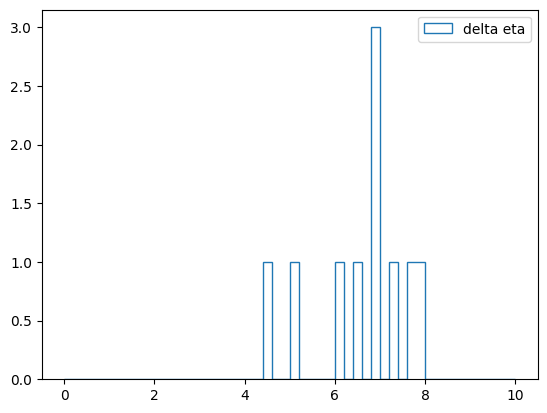

In [10]:
# plot delta eta
plt.figure()
plt.hist(abs(vbf_quarks_last.eta[:,0] - vbf_quarks_last.eta[:,1]), bins=50, range=(0,10), histtype='step', label='delta eta')
plt.legend(loc='upper right')
plt.show()

In [11]:
vbf_quarks_last_opposite_eta=vbf_quarks_last[vbf_quarks_last.eta[:,0]*vbf_quarks_last.eta[:,1]<0]

print("len vbf_quarks_last_opposite_eta", len(vbf_quarks_last_opposite_eta))
print("len vbf_quarks_last", len(vbf_quarks_last))
print("ratio opposite eta", len(vbf_quarks_last_opposite_eta)/len(vbf_quarks_last))


len vbf_quarks_last_opposite_eta 10
len vbf_quarks_last 10
ratio opposite eta 1.0


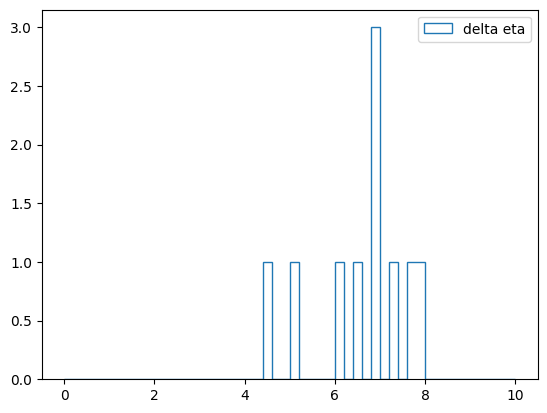

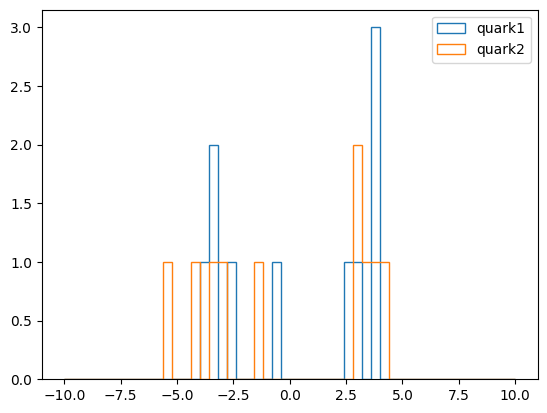

In [12]:

#plot delta eta for opposite eta
plt.figure()
plt.hist(abs(vbf_quarks_last_opposite_eta.eta[:,0] - vbf_quarks_last_opposite_eta.eta[:,1]), bins=50, range=(0,10), histtype='step', label='delta eta')
plt.legend(loc='upper right')
plt.show()

#plot eta for opposite eta
plt.figure()
plt.hist(vbf_quarks_last_opposite_eta.eta[:,0], bins=50, range=(-10,10), histtype='step', label='quark1')
plt.hist(vbf_quarks_last_opposite_eta.eta[:,1], bins=50, range=(-10,10), histtype='step', label='quark2')
plt.legend(loc='upper right')
plt.show()

# VBF parton matching with numba

In [13]:
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
genpart= events.GenPart
single_event=-1
if (single_event!=-1):
    genpart= events.GenPart[single_event]


isQuark = abs(genpart.pdgId) < 7
isLast = genpart.hasFlags(["isLastCopy"])
isFirst = genpart.hasFlags(["isFirstCopy"])
isHard = genpart.hasFlags(["fromHardProcess"])

quarks = genpart[isQuark & isHard]
quarks = quarks[quarks.genPartIdxMother!=-1]

quarks_mother = genpart[quarks.genPartIdxMother]
quarks_mother_children = quarks_mother.children
quarks_mother_children_isH = ak.sum((quarks_mother_children.pdgId == 25), axis=-1)==2
print(quarks_mother_children_isH, quarks_mother_children_isH[0])
print(quarks.pdgId, quarks.genPartIdxMother, quarks.index)
vbf_quarks = quarks[quarks_mother_children_isH]
print(vbf_quarks.pdgId, vbf_quarks.genPartIdxMother, vbf_quarks.index, genpart[vbf_quarks.genPartIdxMother].pdgId)
print(vbf_quarks.hasFlags(["isFirstCopy"]))



# plt.hist(ak.flatten(vbf_quarks.hasFlags(["isFirstCopy"])), bins=50, range=(0,10), histtype='step', label='delta eta')
vbf_quarks_first= genpart[isQuark & isFirst & isHard]
vbf_quarks_first= vbf_quarks_first[vbf_quarks_first.genPartIdxMother!=-1]


[[True, True, False, False, False, False, ... False, False, False, False, False]] [True, True, False, False, False, False, ... False, False, False, False, False]
[[2, 2, 5, -5, 5, -5, 5, 5, 2, 2, -5, 5, ... 2, 1, 5, -5, 5, -5, 2, 1, 5, -5, 5, -5]] [[0, 0, 10, 10, 11, 11, 12, 14, 5, 4, 15, ... 10, 10, 11, 11, 4, 5, 12, 13, 14, 15]] [[4, 5, 12, 13, 14, 15, 17, 18, 20, 21, ... 12, 13, 14, 15, 16, 17, 19, 20, 23, 24]]
[[2, 2], [2, 1], [4, 1], [4, 1], [1, -1], [2, 1], [2, 1], [2, 1], [4, 1], [2, 1]] [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] [[4, 5], [4, 5], [4, 5], [4, 5], [4, 5], [4, 5], [4, 5], [4, 5], [4, 5], [4, 5]] [[2, 2], [1, 1], [2, 2], [2, 2], [-2, -2], ... 2, 2], [2, 2], [2, 2], [3, 3], [1, 1]]
[[False, False], [False, False], [True, ... False], [True, True], [False, False]]


In [14]:
@njit
def analyze_parton_from_vbf_quarks(vbf_quarks_array, genpart_array):
    # find the last copy of the vbf quarks
    for i in range(len(vbf_quarks_array)):
        vbf_quarks = vbf_quarks_array[i]
        print("vbf_quarks", vbf_quarks.pdgId, vbf_quarks.genPartIdxMother, vbf_quarks.index)
        vbf_quarks_last = vbf_quarks
        while True:
            vbf_quarks_children = genpart_array[vbf_quarks_last.childrenIdx]
            print("vbf_quarks_last", vbf_quarks_last.pdgId, vbf_quarks_last.genPartIdxMother, vbf_quarks_last.index)
            print("vbf_quarks_children", vbf_quarks_children.pdgId, vbf_quarks_children.genPartIdxMother, vbf_quarks_children.index)
            break


In [15]:
analyze_parton_from_vbf_quarks(vbf_quarks, genpart)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at resolving type of attribute "childrenIdx" of "vbf_quarks_last".
array does not have a field with key 'childrenIdx'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/_connect/_numba/layout.py#L339)
During: typing of get attribute at /tmp/ipykernel_65981/1949024060.py (9)
Enable logging at debug level for details.

File "../../../../tmp/ipykernel_65981/1949024060.py", line 9:
<source missing, REPL/exec in use?>


# Alternative approach

In [ ]:
@njit
def get_last_copy_vbf_quarks(
    vbf_quarks_first_pdgId,
    vbf_quarks_first_children_idx,
    genpart_pdgId,
    genpart_index,
    genpart_isLastCopy,
    genpart_children_idx,
):
    out = np.zeros((len(vbf_quarks_first_pdgId), 2), dtype="int64")
    for i in range(len(vbf_quarks_first_pdgId)):
        vbf_quarks_first_pdgId_i = vbf_quarks_first_pdgId[i]
        vbf_quarks_first_children_idx_i = vbf_quarks_first_children_idx[i]
        genpart_pdgId_i = genpart_pdgId[i]
        genpart_index_i = genpart_index[i]
        genpart_isLastCopy_i = genpart_isLastCopy[i]
        genpart_children_idx_i = genpart_children_idx[i]

        for j in range(len(vbf_quarks_first_pdgId_i)):
            vbf_quark_first_pdgId_j = vbf_quarks_first_pdgId_i[j]
            vbf_quark_first_children_idx_j = vbf_quarks_first_children_idx_i[j]
            genpart_pdgId_j = genpart_pdgId_i[vbf_quark_first_children_idx_j]
            genpart_index_j = genpart_index_i[vbf_quark_first_children_idx_j]
            genpart_isLastCopy_j = genpart_isLastCopy_i[vbf_quark_first_children_idx_j]
            genpart_children_idx_j = genpart_children_idx_i[vbf_quark_first_children_idx_j]

            while True:
                print(genpart_pdgId_j, genpart_index_j, genpart_isLastCopy_j, genpart_children_idx_j)
                if genpart_isLastCopy_j:
                    break
                genpart_pdgId_j = genpart_pdgId_i[genpart_children_idx_j]
                genpart_index_j = genpart_index_i[genpart_children_idx_j]
                genpart_isLastCopy_j = genpart_isLastCopy_i[genpart_children_idx_j]
                genpart_children_idx_j = genpart_children_idx_i[genpart_children_idx_j]

In [ ]:
filename ="/pnfs/psi.ch/cms/trivcat/store/mc/Run3Summer22EENanoAODv12/VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/a897cbbf-ea0b-40d5-b850-f9f24a7906a5.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=10).events()
print("Events read:", len(events))


Events read: 10


In [ ]:
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
genpart= events.GenPart
isFirst = genpart.hasFlags(["isFirstCopy"])
isHard = genpart.hasFlags(["fromHardProcess"])
isHiggs = genpart.pdgId == 25

higgs=(genpart[isHiggs & isHard & isFirst])#[:,0]
print(higgs.pdgId, higgs.genPartIdxMother)
print("ak.local_index(events.GenPart, axis=1)", ak.local_index(events.GenPart, axis=0))
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
higgs_mother=genpart[ak.local_index(events.GenPart.pt, axis=0), higgs.genPartIdxMother]
print(higgs_mother.pdgId)
higgs_mother_children=higgs_mother.children
print(higgs_mother_children.pdgId)
higgs_mother_children_isQuark = abs(higgs_mother_children.pdgId) < 7
print(higgs_mother_children_isQuark)
vbf_quarks_first=higgs_mother_children[higgs_mother_children_isQuark]
print(vbf_quarks_first.pdgId)
print(vbf_quarks_first.children.index, len(vbf_quarks_first.children.pdgId))


genparts_offsets = ak.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genpart, axis=1), allow_missing=True))])
print(genparts_offsets)
print(vbf_quarks_first.childrenIdxG)
vbf_quarks_first_children_idx_flat=ak.flatten(vbf_quarks_first.childrenIdxG, axis=-1)+genparts_offsets[:-1]
print(vbf_quarks_first_children_idx_flat)





# genparts_flat = ak.flatten(genpart)


# print("genparts_flat", genparts_flat)
# print(genparts_offsets)

# print(vbf_quarks_first_children_idx_flat)

# vbf_quarks_first_pdgId = ak.without_parameters(vbf_quarks_first.pdgId, behavior={})
# vbf_quarks_first_children_idx = ak.without_parameters(
#     vbf_quarks_first.children.index, behavior={}
# )
# genpart_pdgId = ak.without_parameters(genpart.pdgId, behavior={})
# genpart_index = ak.without_parameters(genpart.index, behavior={})
# genpart_isLastCopy = ak.without_parameters(
#     genpart.hasFlags(["isLastCopy"]), behavior={}
# )
# genpart_children_idx = ak.without_parameters(genpart.children.index, behavior={})

# get_last_copy_vbf_quarks(
#     vbf_quarks_first_pdgId,
#     vbf_quarks_first_children_idx,
#     genpart_pdgId,
#     genpart_index,
#     genpart_isLastCopy,
#     genpart_children_idx,
# )

[[25, 25], [25, 25], [25, 25], [25, 25], ... [25, 25], [25, 25], [25, 25], [25, 25]] [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
ak.local_index(events.GenPart, axis=1) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


ValueError: cannot mix jagged slice with NumPy-style advanced indexing

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/libawkward/array/ListArray.cpp#L1785)

number of quarks in the event

[[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  1.,  1.,  0.,  9., 11.,
         3.,  3., 20.,  0.,  0.,  0.,  0.]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 [<matplotlib.patches.Polygon at 0x7f89a10e4a00>])

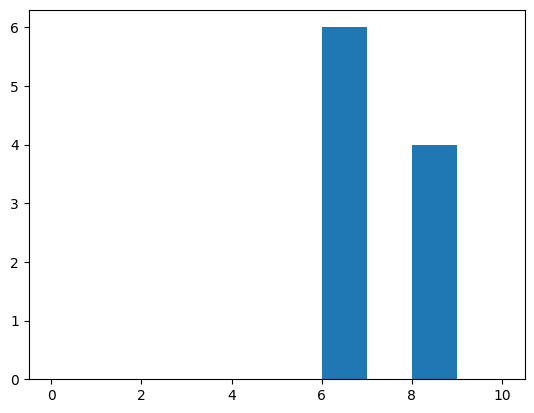

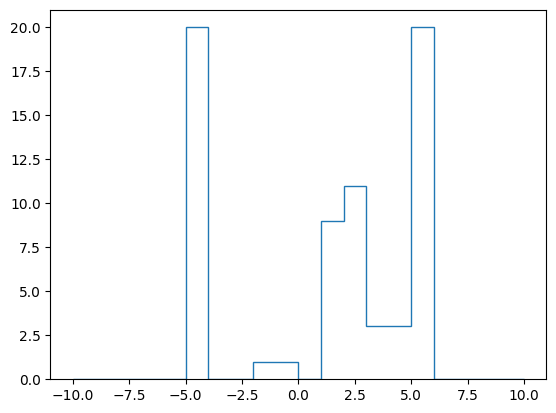

In [ ]:
quarks = events.GenPart[(abs(events.GenPart.pdgId) < 7) & (events.GenPart.hasFlags(["isLastCopy"])) & (events.GenPart.hasFlags(["fromHardProcess"]))]
print(quarks)
num_quarks = ak.num(quarks, axis=1)
plt.hist(num_quarks, bins=10, range=(0, 10))
#plot pdgId of the quarks
plt.figure()
plt.hist(ak.flatten(quarks.pdgId), bins=20, range=(-10,10), histtype='step', label='quark')